In [87]:
import os, sys, json, glob, itertools, random
from dataclasses import dataclass
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"       
os.environ["TF_DETERMINISTIC_OPS"] = "1"        

import sys
import tensorflow as tf

print("Python:", sys.version)
print("TensorFlow:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("Physical GPUs:", tf.config.list_physical_devices('GPU'))


Python: 3.12.6 | packaged by conda-forge | (main, Sep 22 2024, 14:16:49) [GCC 13.3.0]
TensorFlow: 2.18.0
Num GPUs Available: 2
Physical GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [88]:
# === 1. CONFIG ===
@dataclass
class Config:
  
    data_dir: str = "/home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/dataset"
    predict_dir: str = "/home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/predict_samples"
    img_size: int = 128      
    batch_size: int = 8      
    seed: int = 42
    epochs: int = 10
    models_dir: str = "/home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/models"

cfg = Config()
os.makedirs(cfg.models_dir, exist_ok=True)
cfg


Config(data_dir='/home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/dataset', predict_dir='/home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/predict_samples', img_size=128, batch_size=8, seed=42, epochs=10, models_dir='/home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/models')

## Link Dataset Drive : https://drive.google.com/drive/folders/14htYGHZ86IXBaylLl8XvF1_r4HuDp8AC?usp=drive_link 

In [89]:
# === 2. DATA LOADING ===
def load_datasets(data_dir: str, img_size: int, batch_size: int, seed: int=42):
    data_dir = Path(data_dir)
    train_dir = data_dir / "train"
    val_dir   = data_dir / "val"
    test_dir  = data_dir / "test"

    print(f" Memuat dataset dari: {data_dir.resolve()}")
    print(f" Train: {train_dir}")
    print(f" Val  : {val_dir}")
    print(f" Test : {test_dir}\n")

    train_ds = image_dataset_from_directory(
        train_dir, seed=seed, image_size=(img_size, img_size),
        batch_size=batch_size, shuffle=True)
    val_ds = image_dataset_from_directory(
        val_dir, seed=seed, image_size=(img_size, img_size),
        batch_size=batch_size, shuffle=False)
    test_ds = image_dataset_from_directory(
        test_dir, seed=seed, image_size=(img_size, img_size),
        batch_size=batch_size, shuffle=False)

    class_names = train_ds.class_names
    print(f" Kelas terdeteksi: {class_names}")
    return train_ds, val_ds, test_ds, class_names


train_ds, val_ds, test_ds, class_names = load_datasets(
    cfg.data_dir, cfg.img_size, cfg.batch_size, cfg.seed
)

num_classes = len(class_names)
print(f"\nJumlah kelas: {num_classes}")

 Memuat dataset dari: /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/dataset
 Train: /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/dataset/train
 Val  : /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/dataset/val
 Test : /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/dataset/test

Found 259 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
 Kelas terdeteksi: ['gudeg', 'papeda', 'pempek', 'rendang']

Jumlah kelas: 4


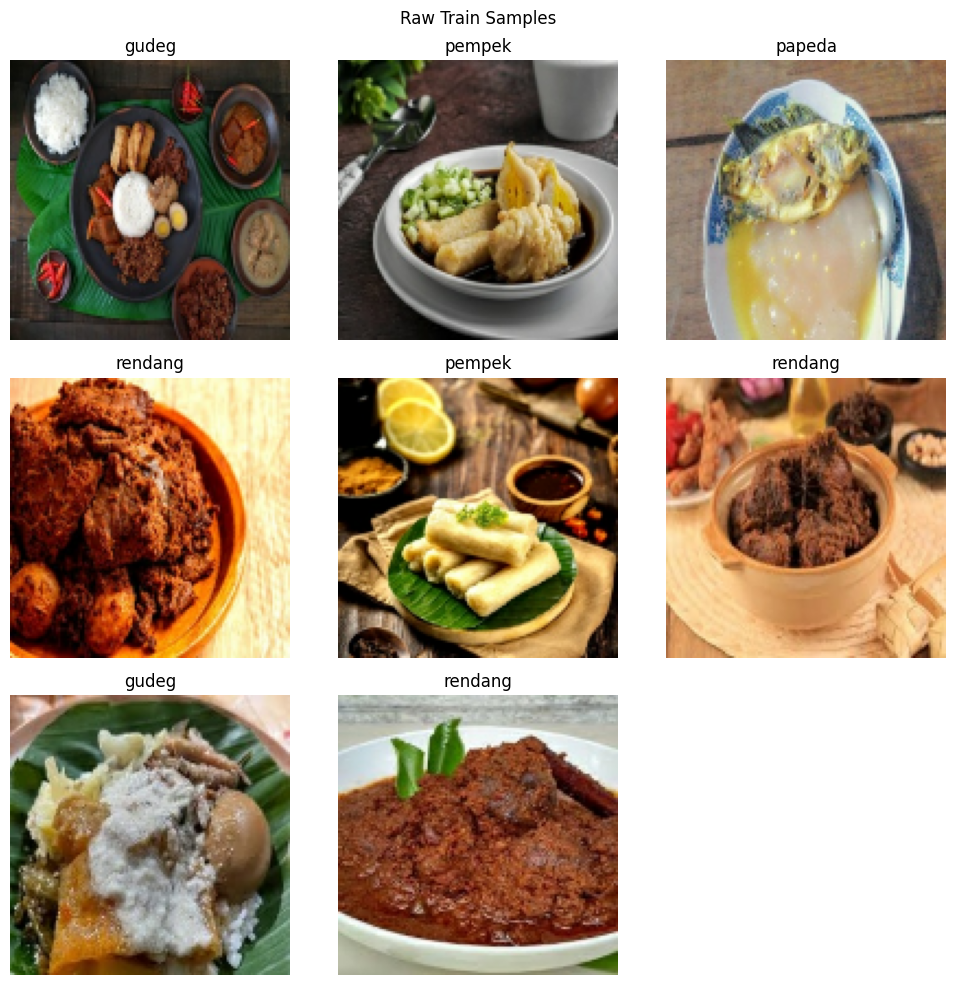

In [90]:
# === 3. DATA VISUALIZATION ===
def show_samples(dataset, class_names, n_images=9, title="Sample Images", denormalize=False):
    plt.figure(figsize=(10,10))
    shown = 0
    for images, labels in dataset.take(1):
        for i in range(min(n_images, images.shape[0])):
            ax = plt.subplot(int(np.ceil(n_images/3)), 3, i+1)
            img = images[i].numpy()
            if denormalize:
                img = np.clip(img*255.0, 0, 255).astype("uint8")
            plt.imshow(img.astype("uint8"))
            plt.title(class_names[int(labels[i])])
            plt.axis("off")
            shown += 1
            if shown >= n_images:
                break
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_ds, class_names, n_images=9, title="Raw Train Samples")

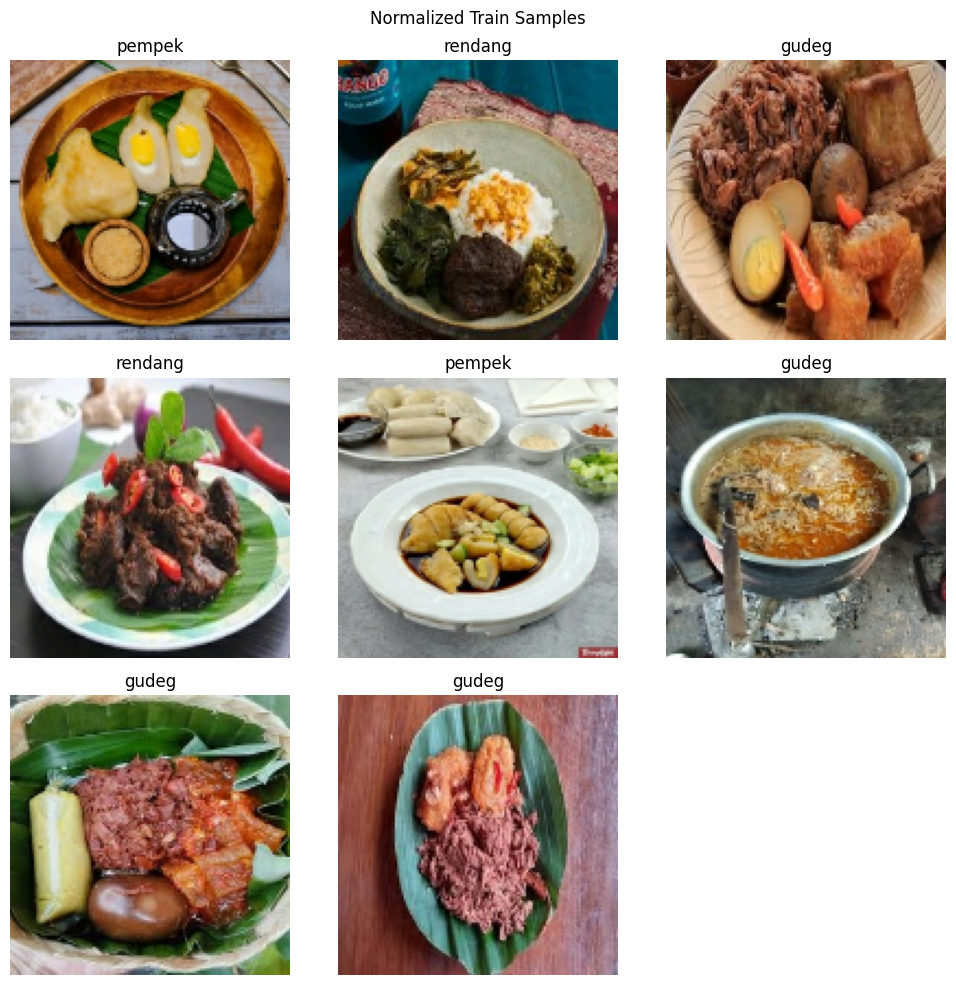

In [91]:
# === 4. DATA PREPARATION ===
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = layers.Rescaling(1./255)

def prepare(ds, shuffle=False):
    ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1024, seed=cfg.seed)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds_prep = prepare(train_ds, shuffle=True)
val_ds_prep   = prepare(val_ds, shuffle=False)
test_ds_prep  = prepare(test_ds, shuffle=False)

show_samples(train_ds_prep, class_names, n_images=9, title="Normalized Train Samples", denormalize=True)

In [92]:
# === 5. MODEL ARCHITECTURES ===
input_shape = (cfg.img_size, cfg.img_size, 3)

# AlexNet 
def build_alexnet(num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 11, strides=4, activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Conv2D(128, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Conv2D(192, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name="AlexNet_Lite")
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

models_builders = {
    "AlexNet_Lite": build_alexnet,
}


for name, fn in models_builders.items():
    m = fn(num_classes)
    print("\n", name)
    m.summary()



 AlexNet_Lite


Model: "AlexNet_Lite"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 192)      │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 128)      │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 935,620 (3.57 MB)

 Trainable params: 935,620 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# === 6. TRAINING ===
histories = {}
val_acc_records = {}
early_stop = callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_accuracy')

for name, builder in models_builders.items():
    print(f"\n===== Training {name} =====")
    tf.keras.backend.clear_session()  
    
    model = builder(num_classes)
    history = model.fit(
        train_ds_prep,
        validation_data=val_ds_prep,
        epochs=cfg.epochs,
        callbacks=[early_stop],
        verbose=1
    )

    # Simpan hasil training
    histories[name] = history.history
    save_path = os.path.join(cfg.models_dir, f"{name}.h5")
    model.save(save_path)
    print(f" Model disimpan ke: {save_path}")
    val_acc_records[name] = float(np.max(history.history['val_accuracy']))

# === Simpan metrik training ===
rows = []
for name, hist in histories.items():
    for i in range(len(hist['accuracy'])):
        rows.append({
            "model": name,
            "epoch": i+1,
            "train_accuracy": hist['accuracy'][i],
            "val_accuracy": hist['val_accuracy'][i],
            "train_loss": hist['loss'][i],
            "val_loss": hist['val_loss'][i]
        })

hist_df = pd.DataFrame(rows)
csv_path = os.path.join(cfg.models_dir, "training_metrics_AlexNet.csv")
hist_df.to_csv(csv_path, index=False)

print(f"\n Log disimpan ke: {csv_path}")
print("\n Validation Accuracy:")
for n, a in val_acc_records.items():
    print(f"{n:12s}: {a:.4f}")


===== Training AlexNet_Lite =====
Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2952 - loss: 1.3896 - val_accuracy: 0.2500 - val_loss: 1.3788
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2401 - loss: 1.4011 - val_accuracy: 0.4062 - val_loss: 1.3770
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2805 - loss: 1.3805 - val_accuracy: 0.4375 - val_loss: 1.3529
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3858 - loss: 1.3376 - val_accuracy: 0.4688 - val_loss: 1.2052
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4762 - loss: 1.2140 - val_accuracy: 0.5312 - val_loss: 1.0754
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5372 - loss: 1.0836 - val_accuracy: 0.5625 - val_loss: 0.9810
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5056 - loss: 0.9649 - val_accuracy: 0.5938 - val_loss: 0.9454
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5803 - loss: 0.972

 Model disimpan ke: /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/models/AlexNet_Lite.h5

 Log disimpan ke: /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/models/training_metrics_AlexNet.csv

 Validation Accuracy:
AlexNet_Lite: 0.6562


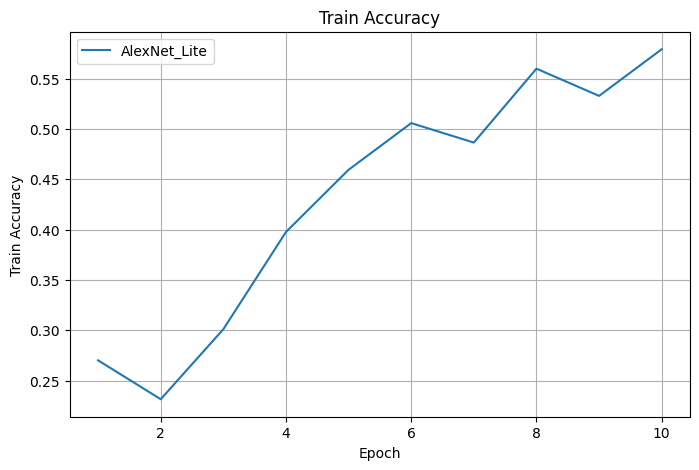

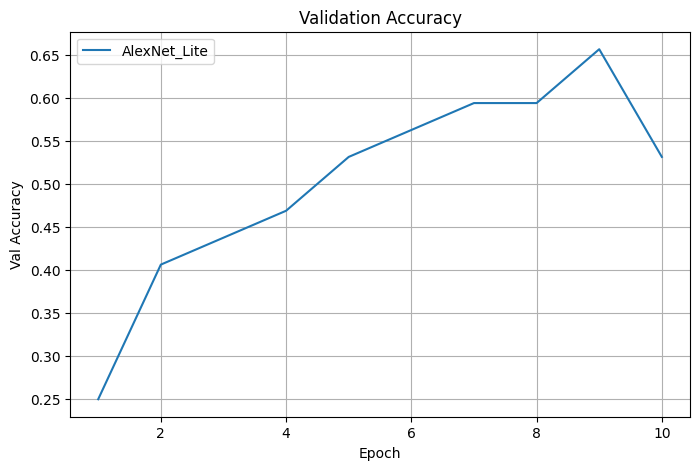

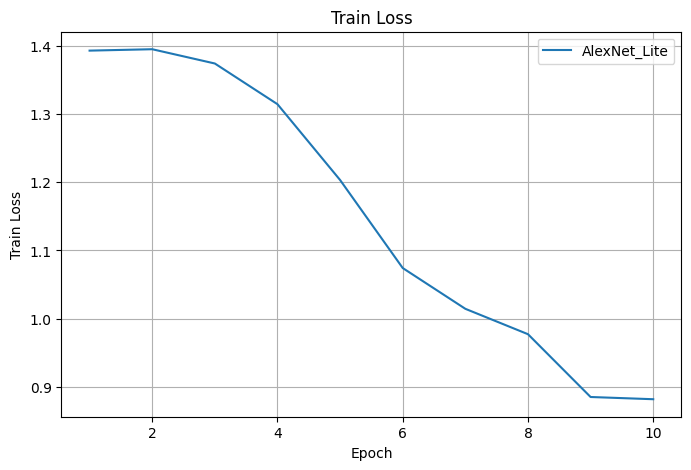

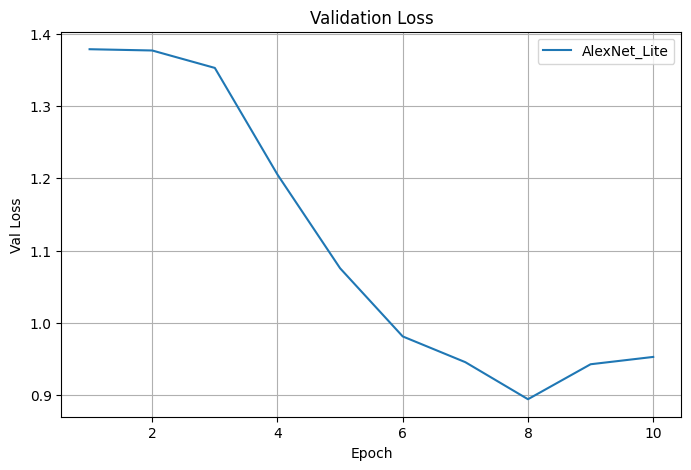

In [94]:
# === 6b. GRAFIK METRIK ===
def plot_metric(df, metric, title=None):
    plt.figure(figsize=(8,5))
    for name in df['model'].unique():
        x = df[df['model']==name]['epoch']
        y = df[df['model']==name][metric]
        plt.plot(x, y, label=name)
    plt.xlabel("Epoch")
    plt.ylabel(metric.replace("_"," ").title())
    plt.title(title or f"Training Curves – {metric}")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(hist_df, "train_accuracy", "Train Accuracy")
plot_metric(hist_df, "val_accuracy", "Validation Accuracy")
plot_metric(hist_df, "train_loss", "Train Loss")
plot_metric(hist_df, "val_loss", "Validation Loss")

 Evaluating model: /home/jupyter-230712427/Projek UAS PMDPM_A_Pingouin/budaya_nusantara_foods/models/AlexNet_Lite.h5


2025-10-26 12:06:03.009985: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}



 Test Accuracy (AlexNet_Lite): 0.5625

              precision    recall  f1-score   support

       gudeg       0.50      0.25      0.33         8
      papeda       0.80      0.50      0.62         8
      pempek       0.60      0.75      0.67         8
     rendang       0.46      0.75      0.57         8

    accuracy                           0.56        32
   macro avg       0.59      0.56      0.55        32
weighted avg       0.59      0.56      0.55        32



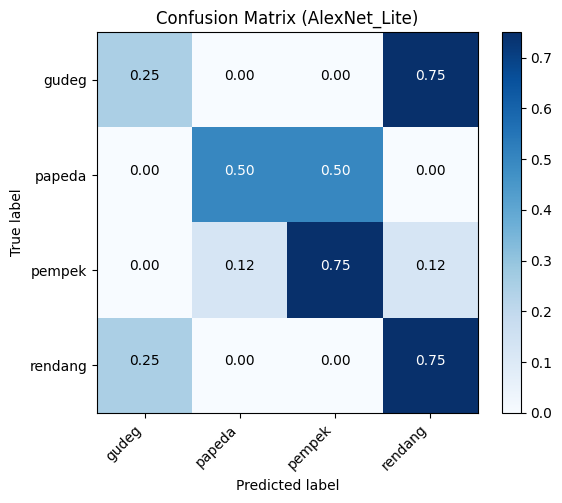

In [95]:
# === 7. EVALUATION (AlexNet_Lite Only) ===

# Tentukan path model AlexNet_Lite
model_path = os.path.join(cfg.models_dir, "AlexNet_Lite.h5")
print(" Evaluating model:", model_path)

# Load model
alexnet_model = tf.keras.models.load_model(model_path)

# Kumpulkan label asli & prediksi dari test set
y_true, y_pred = [], []
for images, labels in test_ds_prep:
    probs = alexnet_model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(preds.tolist())

# Ubah ke numpy array
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Hitung akurasi
acc = (y_true == y_pred).mean()
print(f"\n Test Accuracy (AlexNet_Lite): {acc:.4f}\n")

# Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=class_names))

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion Matrix (AlexNet_Lite)'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha='right')
    plt.yticks(ticks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Tampilkan confusion matrix
plot_confusion_matrix(cm, class_names, normalize=True)


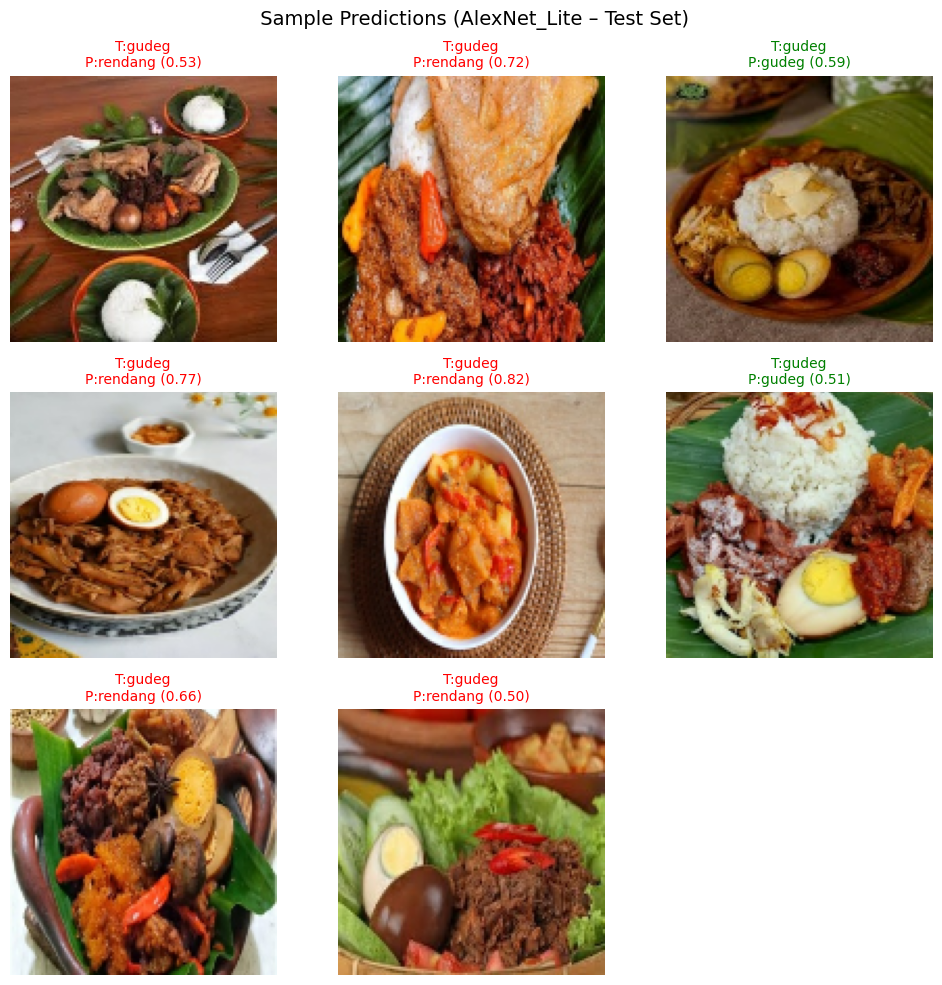

In [96]:
# === 7b. VISUAL CONTOH PREDIKSI (AlexNet_Lite – Test Set) ===
def show_predictions_alexnet(dataset, model, class_names, n_images=9):
    """
    Menampilkan contoh hasil prediksi dari model AlexNet_Lite pada test set.
    Gambar dengan judul hijau = prediksi benar, merah = salah.
    """
    plt.figure(figsize=(10, 10))
    count = 0

    # Ambil 1 batch dari test dataset
    for images, labels in dataset.take(1):
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)

        for i in range(min(n_images, images.shape[0])):
            ax = plt.subplot(int(np.ceil(n_images / 3)), 3, i + 1)
            img = np.clip(images[i].numpy() * 255.0, 0, 255).astype("uint8")

            plt.imshow(img)
            true_label = class_names[int(labels[i])]
            pred_label = class_names[int(preds[i])]
            conf = np.max(probs[i])

            # Warna hijau jika benar, merah jika salah
            color = "green" if true_label == pred_label else "red"
            title = f"T:{true_label}\nP:{pred_label} ({conf:.2f})"
            plt.title(title, color=color, fontsize=10)
            plt.axis("off")

            count += 1
            if count >= n_images:
                break

    plt.suptitle(" Sample Predictions (AlexNet_Lite – Test Set)", fontsize=14)
    plt.tight_layout()
    plt.show()


# === Jalankan visualisasi untuk AlexNet_Lite ===
show_predictions_alexnet(test_ds_prep, alexnet_model, class_names, n_images=9)


In [97]:
# === 8. PREDIKSI 10 GAMBAR PER KELAS (predict_samples/<kelas>) – AlexNet_Lite ===

def load_predict_images(predict_dir, class_names, img_size=cfg.img_size, per_class=10):
    """
    Memuat maksimal 10 gambar dari setiap kelas di folder predict_samples/<kelas>
    untuk diuji dengan model AlexNet_Lite.
    """
    records = []
    predict_dir = Path(predict_dir)

    for cls in class_names:
        cls_dir = predict_dir / cls
        if not cls_dir.exists():
            print(f"[⚠️] Folder tidak ditemukan: {cls_dir}")
            continue

        # Ambil maksimal 10 gambar (format umum)
        files = sorted([
            p for p in cls_dir.glob("*")
            if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
        ])[:per_class]

        for fp in files:
            img = Image.open(fp).convert("RGB").resize((img_size, img_size))
            arr = np.array(img).astype("float32") / 255.0
            records.append((cls, str(fp), arr))

    return records


def predict_records_alexnet(model, records, class_names):

    results = []
    for true_cls, path, arr in records:
        x = np.expand_dims(arr, axis=0)
        prob = model.predict(x, verbose=0)[0]
        pred_idx = int(np.argmax(prob))
        pred_cls = class_names[pred_idx]
        conf = float(np.max(prob))

        results.append({
            "true_class": true_cls,
            "image_path": path,
            "pred_class": pred_cls,
            "confidence": conf
        })

    return pd.DataFrame(results)


# === Jalankan Prediksi pada Folder predict_samples ===
records = load_predict_images(cfg.predict_dir, class_names, cfg.img_size, per_class=10)
pred_df = predict_records_alexnet(alexnet_model, records, class_names)

print("Contoh hasil prediksi AlexNet_Lite:")
display(pred_df.head(20))


2025-10-26 12:06:10.611101: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


Contoh hasil prediksi AlexNet_Lite:


true_class                                         image_path pred_class  \
0       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
1       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...    rendang   
2       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...    rendang   
3       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...    rendang   
4       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
5       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
6       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
7       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...    rendang   
8       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...    rendang   
9       gudeg  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
10     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
11     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...     pempek   
12     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...    rendang   
13     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
14     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
15     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...     papeda   
16     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...     papeda   
17     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...     papeda   
18     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...      gudeg   
19     papeda  /home/jupyter-230712427/Projek UAS PMDPM_A_Pin...     papeda   

    confidence  
0     0.563362  
1     0.618356  
2     0.662630  
3     0.655060  
4     0.649056  
5     0.472659  
6     0.454125  
7     0.551390  
8     0.512582  
9     0.616563  
10    0.589546  
11    0.484217  
12    0.430624  
13    0.426426  
14    0.555486  
15    0.519375  
16    0.555749  
17    0.431857  
18    0.335296  
19    0.643025

2025-10-26 12:06:17.789376: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


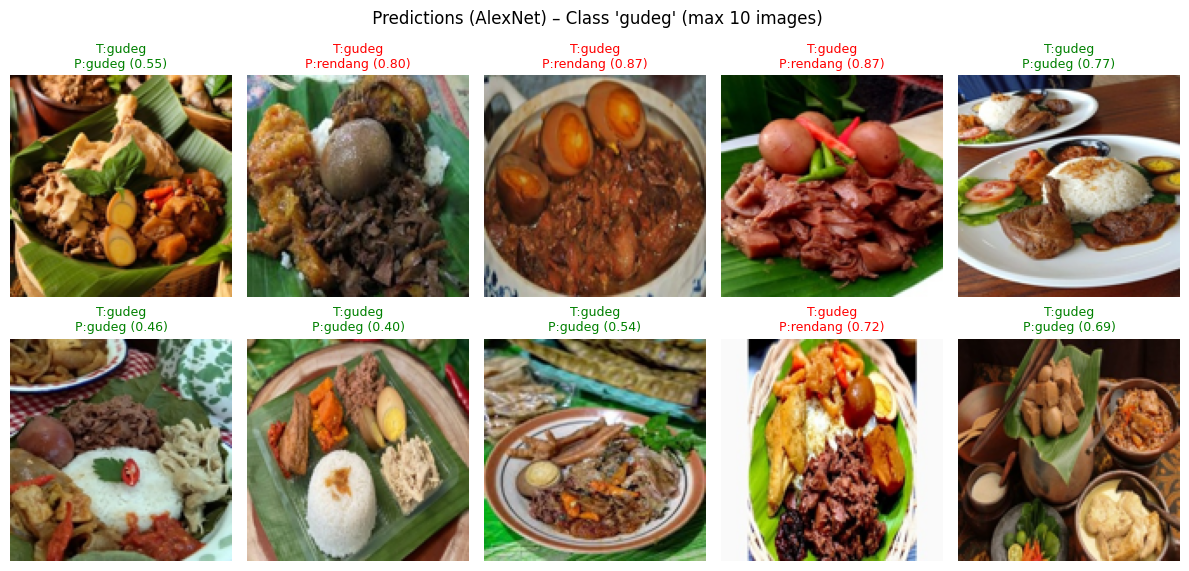

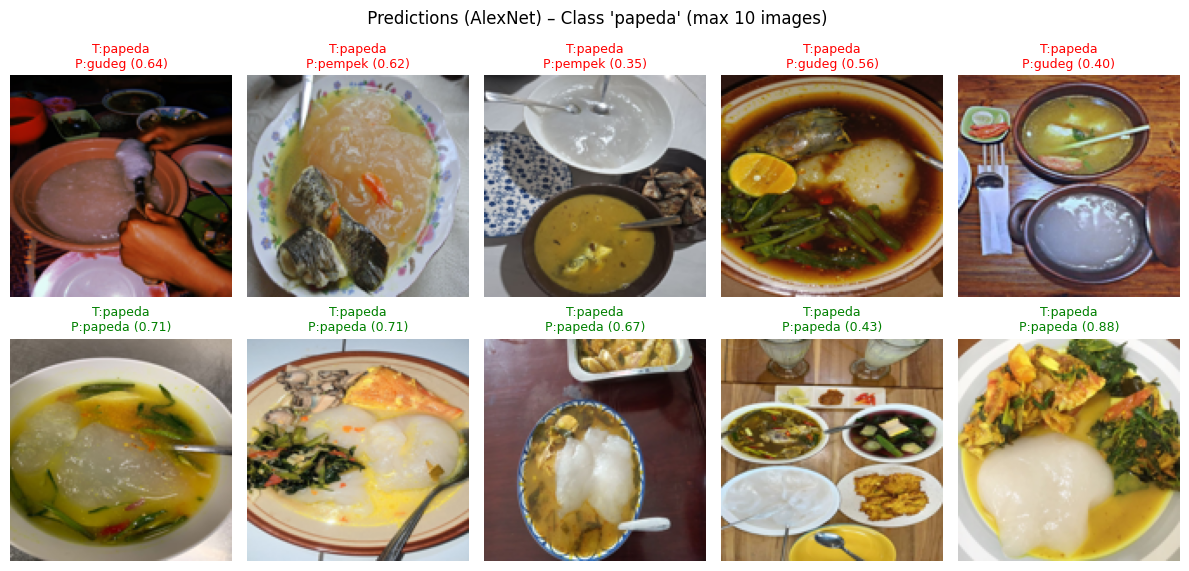

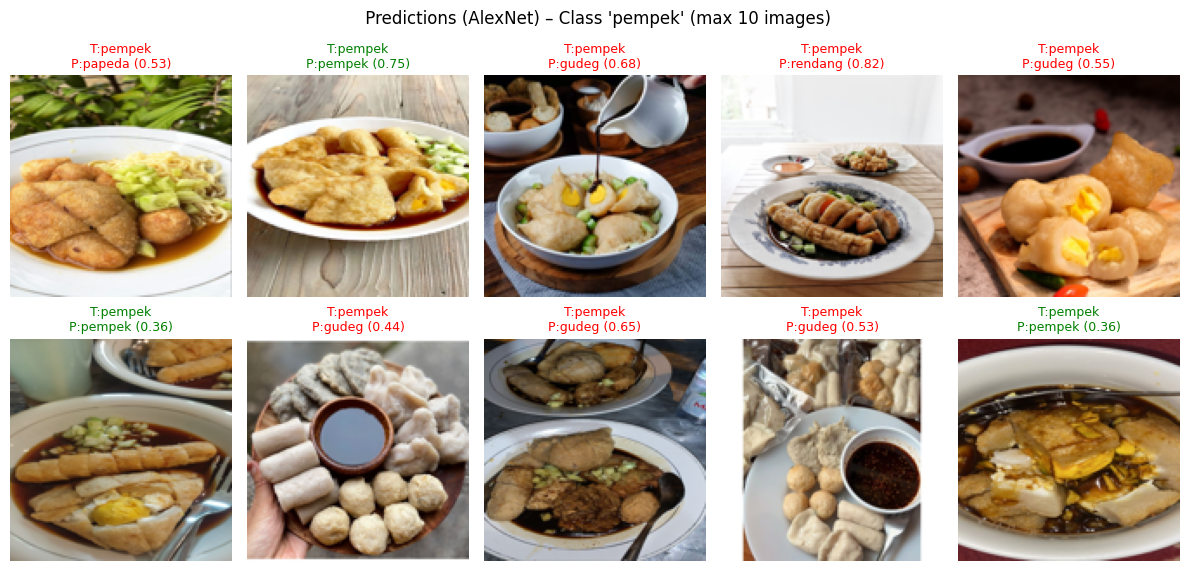

2025-10-26 12:06:22.879728: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


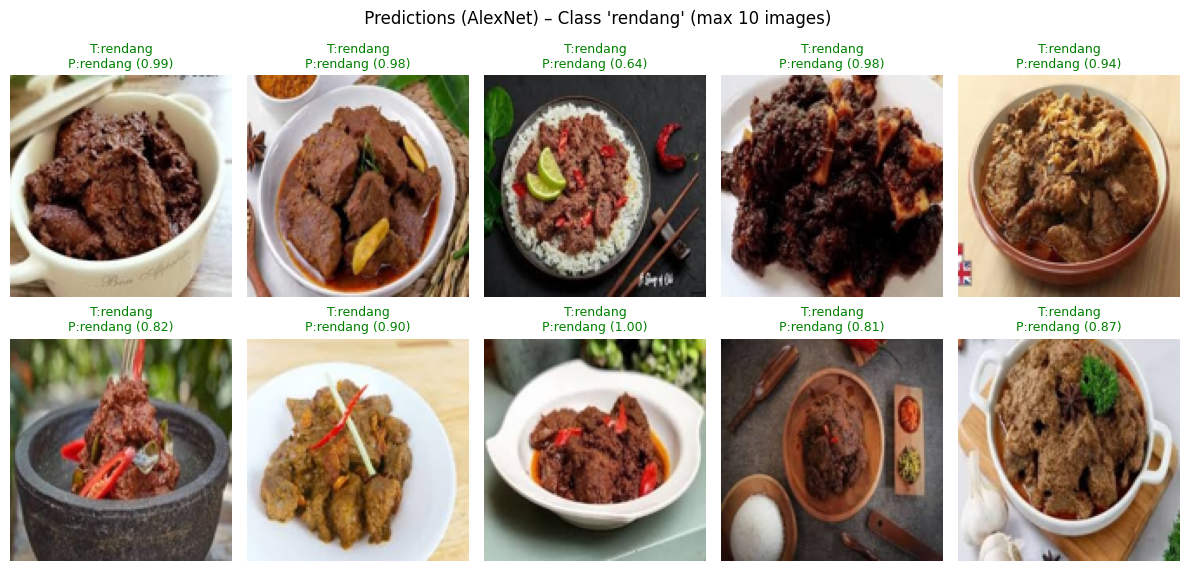

In [98]:
# === 8b. VISUALISASI PREDIKSI PER KELAS (maks 10 gambar) ===
for cls in class_names:
    subset = [r for r in records if r[0]==cls][:10]
    if not subset:
        continue
    plt.figure(figsize=(12,6))
    for i, (true_cls, path, arr) in enumerate(subset):
        ax = plt.subplot(2,5,i+1)
        prob = best_model.predict(np.expand_dims(arr,0), verbose=0)[0]
        pred_idx = int(np.argmax(prob))
        conf = float(np.max(prob))
        pred_cls = class_names[pred_idx]
        plt.imshow((arr*255).astype("uint8"))
        title = f"T:{true_cls}\nP:{pred_cls} ({conf:.2f})"
        color = "green" if true_cls==pred_cls else "red"
        plt.title(title, color=color, fontsize=9)
        plt.axis("off")
    plt.suptitle(f" Predictions (AlexNet) – Class '{cls}' (max 10 images)")
    plt.tight_layout()
    plt.show()